# Load Dataset

In [1]:
import warnings
import numpy as np
import pandas as pd
import random
import torch
import gdown
import scanpy as sc
import evaluate
import models
import gc
warnings.filterwarnings('ignore')

seed = 0
def set_seed(seed):
    """set random seed."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(seed)


dataname = 'PBMC'
adata = sc.read("/home/grads/ywang2542/Perturbation/scPRAM/scOTC/data/PBMC.h5ad")
key_dic = {'condition_key': 'condition',
        'cell_type_key': 'cell_type',
        'ctrl_key': 'control',
        'stim_key': 'stimulated',
        'pred_key': 'predict',
        }

# adata = sc.AnnData(adata.X, obs=adata.obs.copy(), var=adata.var.copy())
adata.obs_names_make_unique()
print(adata)
# print('\n', adata.obs['condition'].value_counts())
# print('\n', adata.obs['cell_type'].value_counts())

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


# Model Training, Evaluation, and Visualization of results

7 ['NK', 'Dendritic', 'CD4T', 'B', 'FCGR3A+Mono', 'CD14+Mono', 'CD8T']
Categories (7, object): ['CD4T', 'CD14+Mono', 'B', 'CD8T', 'NK', 'FCGR3A+Mono', 'Dendritic']


  0%|          | 0/400 [00:00<?, ?it/s]

CD14+Mono
CD14+Mono  common DEGs: 82


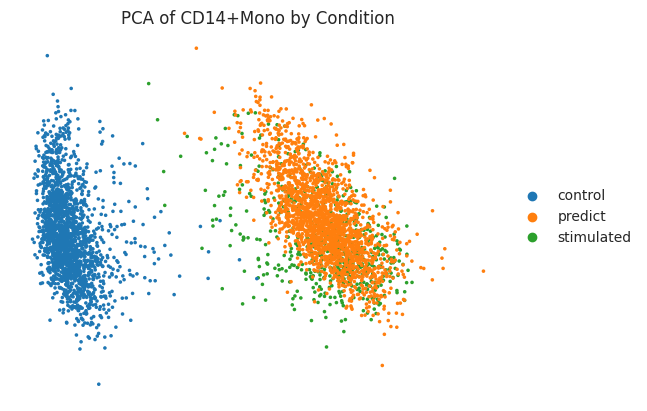

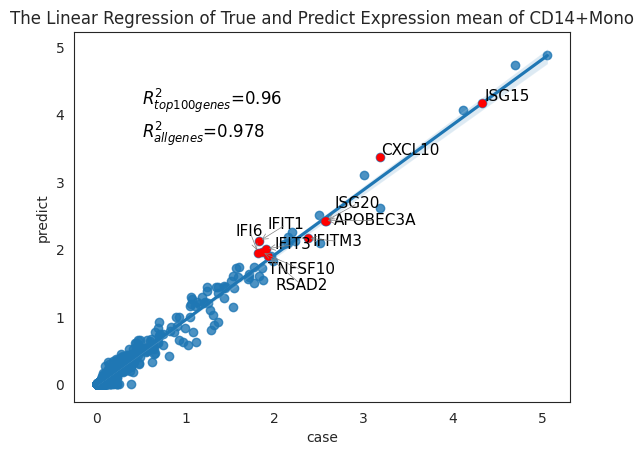

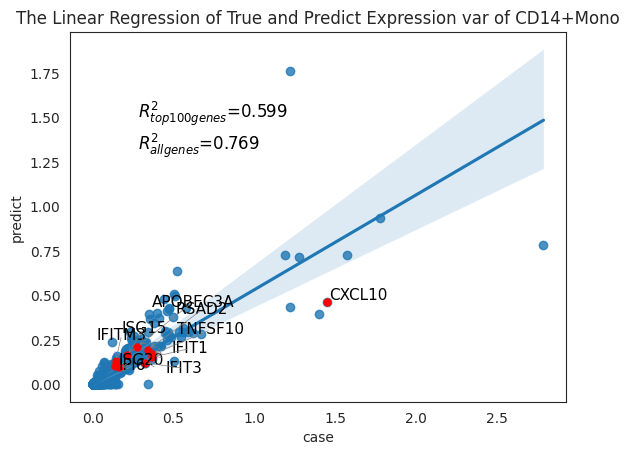

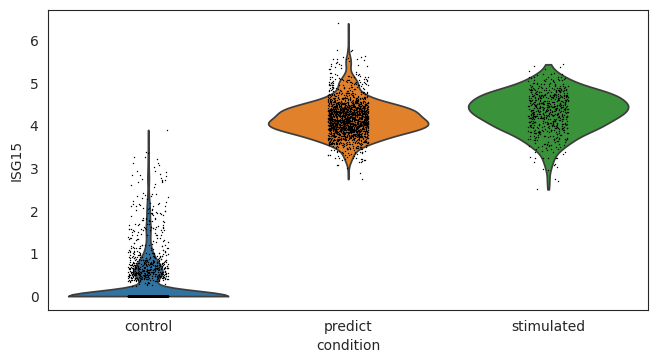

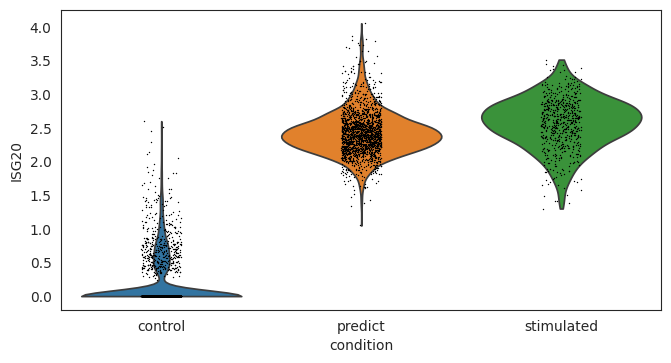

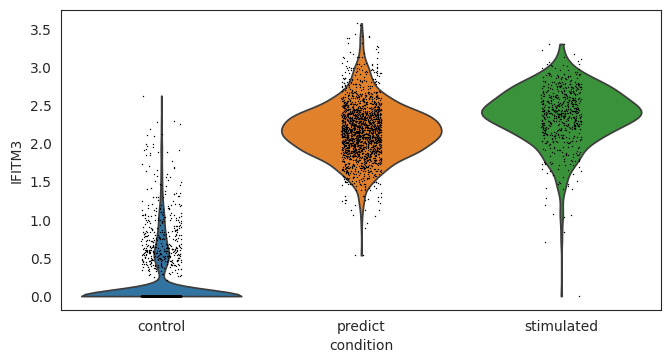

,common DEGs of top 100 genes,mean R2 of all genes expression mean,mean R2 of top 100 genes expression mean,mean R2 of all genes expression var,mean R2 of top 100 expression var,Wasserstein distance of all genes,Wasserstein distance of top 100 genes,std R2 of all genes expression mean,std R2 of top 100 genes expression mean,std R2 of all genes expression var,std R2 of top 100 expression var
CD14+Mono,82.0,0.978798,0.95975,0.768338,0.599444,101.682137,19.225529,0.000384,0.001053,0.005297,0.010653


In [6]:

noise_rate=0.1
num_heads=0
latent_dim=200
hidden_dim=1000
cycle_weight = 0.01
epochs = 400  # 400
lr = 5e-4


celltypelist = adata.obs[key_dic['cell_type_key']].unique()
print(len(celltypelist),celltypelist)
# celltypelist = ["CD14+Mono"] # ['CD4T']
model = models.scOTC(input_dim=adata.n_vars, latent_dim=latent_dim, hidden_dim=hidden_dim, noise_rate=noise_rate, num_heads=num_heads, cycle_weight=cycle_weight, device='cuda:0')
model = model.to(model.device)
cell_to_pred = 'CD14+Mono'

train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
            (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
x_, x_hat_ = model.train_scOTC(train, epochs=epochs,lr=lr,weight_decay=1e-5,batch_size=256)

# Predict
adata_to_pred = adata[((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                    (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']))]
pred,ctrl,stim,test_z = model.predict_new(train_adata=train,
                    cell_to_pred=cell_to_pred,
                    key_dic=key_dic,
                    ratio=0.005,)
# Evaluate
ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
eval_adata = ground_truth.concatenate(pred)
evaluate.evaluate(data_name=dataname,
                eval_adata=eval_adata, 
                key_dic=key_dic, save_path=None, return_fig=False)
     
